In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
val_data = pd.read_csv('validation_emotion.csv')
train_data = pd.read_csv('training_emotion.csv')
test_data = pd.read_csv('test_emotion.csv')

In [3]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


In [4]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)


new Vald data : (3000, 2)
new Test data : (1000, 2)


In [5]:
train_data.head(10)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [6]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
train_data.groupby(["label_name","label"]).size()


label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

<AxesSubplot:>

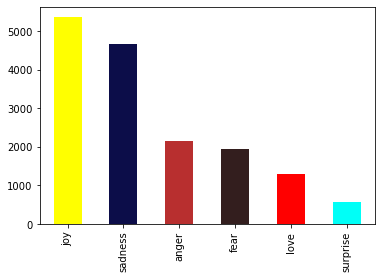

In [8]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

In [9]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [10]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [11]:
all_list

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [12]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Nombre of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))


Nombre of words without Stemming: 17096
Nombre of words with Stemming: 11705


In [13]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']]) 
    return new_data

In [14]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])  

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [15]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])    

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [16]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [17]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


In [18]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [19]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)
        
for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [20]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)


(16000, 66) (16000,)
(3000, 66) (3000,)


In [21]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

In [22]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

C:\Users\himanshu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
500/500 [==============================] - 251s 448ms/step - loss: 1.7679 - accuracy: 0.2931 - val_loss: 1.5916 - val_accuracy: 0.3540
Epoch 2/25
500/500 [==============================] - 222s 444ms/step - loss: 1.6979 - accuracy: 0.2999 - val_loss: 1.5830 - val_accuracy: 0.3530
Epoch 3/25
500/500 [==============================] - 219s 438ms/step - loss: 1.5842 - accuracy: 0.3519 - val_loss: 1.5096 - val_accuracy: 0.4140
Epoch 4/25
500/500 [==============================] - 220s 439ms/step - loss: 1.1786 - accuracy: 0.5801 - val_loss: 0.9788 - val_accuracy: 0.6653
Epoch 5/25
500/500 [==============================] - 211s 421ms/step - loss: 0.7990 - accuracy: 0.7296 - val_loss: 0.6775 - val_accuracy: 0.7667
Epoch 6/25
500/500 [==============================] - 214s 428ms/step - loss: 0.5253 - accuracy: 0.8241 - val_loss: 0.5055 - val_accuracy: 0.8227
Epoch 7/25
500/500 [==============================] - 208s 417ms/step - loss: 0.3963 - accuracy: 0.8607 - val_loss: 0.4479 -

In [23]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.936


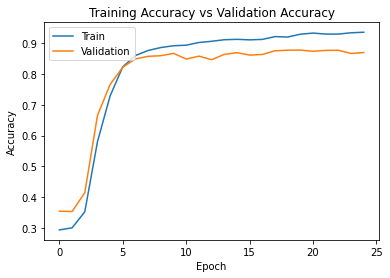

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

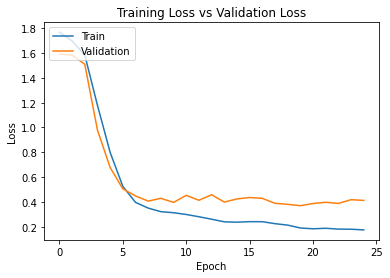

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index
    
    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]
   
    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list

In [27]:
 for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number

    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random value = ',random_number)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 [==============================] - 5s 5s/step

Random value =  523
Predicted Class: 3 anger
Actual Class: 3

1/1 [==============================] - 0s 53ms/step

Random value =  70
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 171ms/step

Random value =  847
Predicted Class: 0 sadness
Actual Class: 0

1/1 [==============================] - 0s 210ms/step

Random value =  471
Predicted Class: 0 sadness
Actual Class: 0

1/1 [==============================] - 0s 134ms/step

Random value =  613
Predicted Class: 5 surprise
Actual Class: 5



In [30]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)
        
test_X = np.array(test_X) 
test_y = np.array(test_y)  

test_y_one_hot = to_categorical(test_y, num_classes=8000)

In [31]:
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 [==============================] - 74s 147ms/step


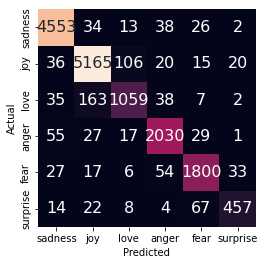

In [32]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()
